$$
\newcommand{\bra}[1]{\langle #1 |}
\newcommand{\ket}[1]{| #1 \rangle}
$$

# Carlos Aráoz Alvarado

# 6.12 ▶ Final Assignment: Advanced Algorithms Design (session: July 8) 🏆 Final Assignment for Classiq Certificate 2 🏆

# Discrete-time quantum walk

Discrete quantum walks are the quantum analogs of classical random walks, playing a significant role in the field of quantum computing and quantum information theory. Unlike classical random walks, where a walker moves between nodes of a graph based on certain probabilities, quantum walks utilize quantum superposition and interference to explore multiple paths simultaneously. This property enables quantum walks to perform computational tasks more efficiently than their classical counterparts.

Quantum walks can be categorized into two main types: discrete-time and continuous-time quantum walks. Discrete quantum walks are defined by a set of discrete steps on a lattice or graph, where the walker’s position and coin state (representing the direction) are updated at each step through a unitary transformation. The evolution of the system is governed by the W_operator and S_operator, which together define the dynamics of the walk.

Applications of discrete quantum walks span various domains, including quantum search algorithms, quantum simulations, and the development of quantum algorithms for solving computational problems more efficiently. They offer a robust framework for exploring the principles of quantum mechanics and developing novel quantum technologies.

# Quantum Walk Operator for a Circle with 4 Nodes


First we will review the example covered in class in detail. 

The goal of this quantum program is to simulate a quantum random walk on a circle topology with 4 nodes.

In a circle topology, the nodes are arranged in a cyclic manner, where each node is connected to its immediate neighbors, and the connections wrap around the circle. For example, consider a circle of 4 nodes numbered from 0 to 3. In this walk, the walker would move from its current node to an adjacent node (either clockwise or counterclockwise) with equal probability.

Let's draw this graph

In [1]:
from collections import defaultdict

import dimod
from dimod import BQM
import dwave_networkx as dnx
from neal import SimulatedAnnealingSampler
import networkx as nx

from bqm_utils import graph_viz, graph_coloring_viz

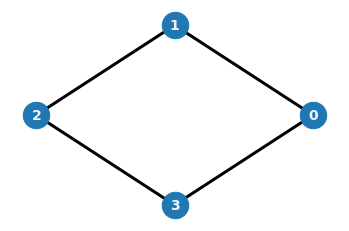

In [2]:
G = nx.Graph()
edges = [(0, 1), (1,2), (2,3), (3,0)]
G.add_edges_from(edges)
graph_viz(G)

$$
\newcommand{\bra}[1]{\langle #1 |}
\newcommand{\ket}[1]{| #1 \rangle}
$$

We make the following assignations:

Nodes/Vertices: V

Edges- connected vertices: E

$V={0,1,2,3}$

$E=\{(0,1),(1,2), (2,3), (3,0)+symm\}$


## Encoding



Following the paper **Lecture notes on Quantum Algorithms** (Ref[1]) on chapter 17.1 we encounter the following sentence **$\ket{j}$ corresponding to the vertex $j \in V$**.  This indicates that $\ket{j}$ encodes a vertex $j$.

A quantum state represents either a number or a superposition of numbers. For example, it can be a superposition of node zero and node one, expressed as $\ket{0}+\ket{1}$. This section of the paper discusses how to encode our data, specifically how vertices are encoded into quantum states. These states are represented by numbers or superpositions of numbers.

To achieve this encoding, we use QNum from the classic QMod language. QNum allows us to represent quantum states as numbers. In this case, we are dealing with integer numbers, so we use a simple QNum. We can define it as follows:

`output vertices:qnum`

Here, vertices is a quantum variable of type qnum, representing the encoded quantum states of our vertices.


However, there is a caveat. The paper states:  **Let the Hilbert space consist of states of the form $\ket{j,k}$ where $(j,k) \in E$**. This implies that $\ket{k}$ also encodes a vertex.

Thus, we need to encode another quantum variable as vertices, specifically $\ket{k}$. It's important to note that we only need connected vertices, which we will address later. At a high level, we understand that we need another quantum variable, QNum, to represent adjacent vertices. We can define it as follows:

`output adjacent_vertices:qnum`

Here, adjacent_vertices is a quantum variable of type qnum, representing the encoded quantum states of our adjacent vertices.

## Evolution & Encoding

In the paper, we encounter the definition of two operators, C (or the W operator) and S. It is stated that "**Overall, one step of the discrete-time quantum walk is described by the unitary operator SC**. Our goal is to implement the operator composed of S and C, and then iteratively apply it consecutively. Thus, the evolution part of the quantum walk involves applying these two operators on the states defined in the encoding part.

Let's start with the following operator:

$$C := \sum_{j \in V} \ket{j}\bra{j} \otimes (2\ket{\partial_j}\bra{\partial_j}-I)$$

Here, we sum over all the vertices in the set V (in our graph). One way to express this is by performing a Hadamard transform over all the vertices. Another method is to use a repeat construct:


`repeat(i:2**(vertices.size)-1)`

This allows us to repeat over all the vertices in the set V.

Considering the following operation:


$$
\ket{\partial_j} := \frac{1}{\sqrt{\text{deg}(j)}} \sum_{k:(j,k)\in E} \ket{k}
$$


the definition of  $\ket{\partial_j} $ for a specific index j is to assume an equal superposition of all the vertices that are connected to the vertex j. For example, the state of the $\ket{\partial_0}$ is a superposition of all the vertices connected to 0. In our graph, it is a superposition of vertices 3 and 1.

Suppose we have access to a unitary such that $U_j\ket{0} = \ket{\partial_j}$. Then we can make the following decomposition: $2\ket{\partial_j}\bra{\partial_j}- I=U_j(2\ket{0}\bra{0}-1)U^\dagger_j$ notice that
$(2\ket{0}\bra{0}-1)\ket{0} = \ket{0}$ AND $(2\ket{0}\bra{0}-1)\ket{j  \neq0}=-\ket{j \neq 0}$, 
which is exactly the phase kickback operator  $(2\ket{0}\bra{0}-1)\ket{x} = (-1)^{x \neq 0}\ket{x}$.

Remembering that the phase kickback has the following form:






`
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x) `


`@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)`


`@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)`

If we are now going over the entire implementation, the summation  $\sum_{j \in V}$ is done with the `for i in range(2**size):` loop. This allows us to iterate over all the vertices. For each iteration of the sum, we use a control operation. The term $\ket{j}\bra{j} \otimes$ is a projection on the state $j$, it means that only if the state is j, the corresponding operator is applied. 

In a quantum algorithm using QMode language, this is encoded using the control construct. The control is conditioned on the fact that the vertices == i,  Here, vertices is the quantum variable QNum, and only if QNum vertices equals i, we want to implement a specific quantum operator. Specifically, we want to apply the decomposition of the operator  $(2\ket{\partial_j}\ket{\partial_j}-1)$ into the unitary that prepares it and what we call the zero diffuser. We first do the inplace_prepare_state that implements the state $\ket{U_j}$ on $\ket{0}$ so that it creates the desire state $\ket{\partial_j}$ and the action is to apply the zero_diffuzer $(2\ket{\partial_j}\ket{\partial_j}-1)$ 



`def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')`
    
   ` control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01,target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))`


`@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)`


Now for the following operator 

$$S := \sum_{(j,k) \in E} \ket{j,k}\bra{k,j}$$



we have a sum over all the edges we have in the graph $\sum_{(j,k)}$ so for all the tuples (j,k) that are part of the set E, which represents all the edges, we want to perform a swap. This swap is conditioned on whether the two vertices are actually connected by an edge; if they are not, we do not perform the swap.


What does it mean to have two vertices that are part of an edge? This is where we use an oracle that provides the condition: only the vertices that are part of our edges, or two vertices that contain an edge between them, are considered. The edge_oracle will give us the result. We expect the result to be 1 if the specific value of the QNum vertices and the specific value of the QNum adjacent_vertices are part of our graph. For example, if one component of the vertices is 0 and the other component is 1, we want the qubit res = 1 because we have this edge. If one component of the vertices is 0 and the adjacent vertex is 2, we want the value of res = 0 because there is no edge between 0 and 2.


In summary, the oracle will ask if the values of vertices and adjacent_vertices are connected by an edge, and the result in res will be 1 if yes, and 0 if not. For this specific graph, we consider the condition: only if the sum of two vertices is odd. With this condition, we know that the two vertices are connected by an edge. For example, for 0 and 1, 0+1=1, 1 is odd, so they are connected by an edge. For 1 and 3, 1+3=4, 4 is even, so they are not connected by an edge.



The oracle for this part of the algorithm must be specific to the specific graph, so it is graphic-depentent, but the high-level structure `def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):)` is general for all the oracles in this framework. The fact that for the qubit res we will assign the value 1 if the value of vertices and adjacent_vertices have an edge connecting them is general for all the quantum walk implementation. The graph dependet part for this specific example is given by     `res |= (((vertices+adjacent_vertices)%2) ==1)`, which encodes that only if the sum of two vertices is odd, they have an edge.



`@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices+adjacent_vertices)%2) ==1)`
    



Let's see the full implementation of the S operator. We have two QNum variables, vertices and adjacent_vertices. We initialize another QNum called res and apply the edge oracle. The first thing we want to do is to check for specific values of vertices and adjacent_vertices if they are connected by an edge or not. If the value of res = 1, we apply a bitwise_swap between the vertices and the adjacent_vertices. We don't go over all the edges; we build our S operator in a way that we receive the vertices, but we don't go through the entire set of vertices as we did with the C operator. If they are joined by an edge, we apply the bitwise swap.

`@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))`
  

`@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))`


To initialize our quantum variables, we allocate 2 qubits for vertices, giving us 4 possible values, and initialize them with the Hadamard transform to create a superposition. We also allocate 2 qubits for the adjacent_vertices. After the initialization, we apply the W_operator and S_operator to these qubits.




`@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)
    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)`

Let's dive in to the following quantum state



$$
\ket{\partial_j} := \frac{1}{\sqrt{\text{deg}(j)}} \sum_{k:(j,k)\in E} \ket{k}
$$


For a specific value of j (a specific state), we want to have an equal superposition of all the adjacent vertices. Here, $deg(j)$ represents the number of connected vertices to the specific vertex j.

For example, for state 0, we want to have an equal superposition of vertices 3 and 1, which are adjacent to 0: State=0, prob vec =[0, 0.5, 0, 0.5].

For state 1 we want to have an equal superposition of vertices 0 an 2: State=1, prob vec =[0.5, 0, 0.5, 0]. 

For state 2 we want to have an equal superposition of vertices 1 and 3: State=2, prob vec =[0, 0.5, 0, 0.5]. 

For state 3 we want to have an equal superposition of vertices 0 and 2: State=3, prob vec =[0.5, 0, 0.5, 0]. 

To do this we initialize some probability array to encode the probabilities, for a given j=i we want to have the following state (i+1)% 4 on one side and (i-1)% 4  on the other side.

In a circular structure with 4 nodes, each node is connected to its next and previous nodes, and the connections wrap around the circle. For example:

Node 0 is connected to Node 1 and Node 3 and we see that (0+1)% 4=1 & (0-1)% 4=3

Node 3 is connected to Node 0 and Node 2 and we see that (3+1)% 4=0 & (3-1)% 4=2

This wrapping behavior is implemented using the modulo operator, ensuring that when you reach the end of the list of nodes, you wrap around to the beginning. This generates the desired probability vector, which can be implemented with the inplace_prepare_state to the adjacent_vertices.



`prob = [0,0,0,0]
prob[(i+1)% 4]=0.5
prob[(i-1)% 4]=0.5
print(f'State={i}, prob vec ={prob}')
inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices)`

This operation correspontds to $2\ket{\partial_j}\bra{\partial_j}- I=U_j(2\ket{0}\bra{0}-1)U^\dagger_j$, where the unitary $U$ is the  inplace_prepare_state. The full implementation involves applying the within apply construct, enabling us to apply the operator $2\ket{0}\bra{0}-1$ in the basis transformed by $U_j$ and then returning to the original basis. First, we move to the basis of inplace_prepare_state (this is $U_j$), apply the zero_diffuser, and then apply $U^\dagger_j$.

`control(ctrl=vertices==i,
        operand=lambda: within_apply(
          compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
          action= lambda: zero_diffuzer(adjacent_vertices)))`
          
    


### Code

The full code is given by:

In [3]:
from classiq import *

size = 2 # Number of qubits to represent the vertices 

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)

    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
Opening: https://platform.classiq.io/circuit/746f5fa0-6487-4d14-9451-e427c31e932b?version=0.43.3


The output results:

State=0, prob vec =[0, 0.5, 0, 0.5]

State=1, prob vec =[0.5, 0, 0.5, 0]

State=2, prob vec =[0, 0.5, 0, 0.5]

State=3, prob vec =[0.5, 0, 0.5, 0]

demonstrate that the code correctly implements the superposition of adjacent vertices for each state j. This is verified by the resulting probability vectors, which align with the expected adjacency relations.

The implemented solution successfully achieves the desired state superpositions for a small cyclic graph. The probability vectors match the expected outcomes, indicating that the adjacent vertices are accurately identified and superposed.


After running the circuit we see that we have the following information about it

Depth: 31

Width: 9

Gate count

U : 21

CX : 21

In the building block circuit for this problem we see that first we have the QNum vertices and adjacent_vertices. We first apply the hadamard_transform on vertices, to create an equal superposition of all possible states (positions), allowing the walker to have a non-zero probability of being at any of the 4 nodes and then the W_operator (C operator) and the S_operator are applied.

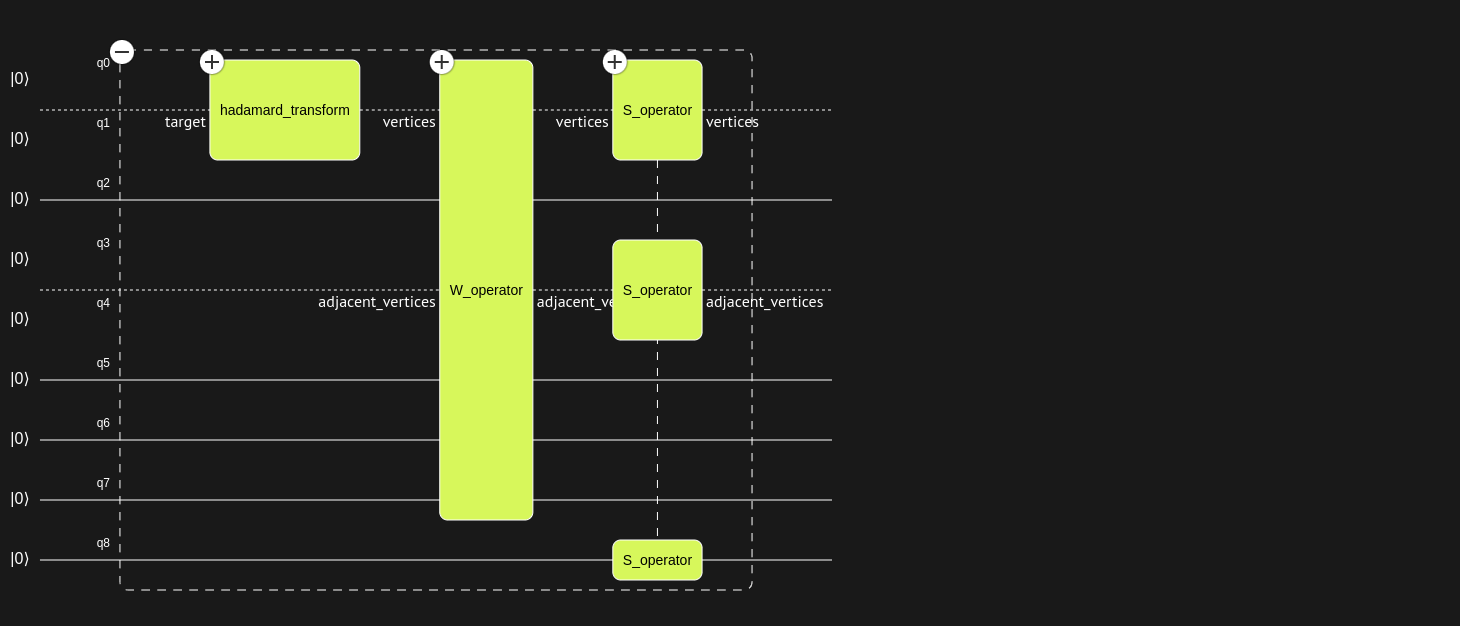

In [12]:
from IPython.display import Image, display

# Display the image
display(Image(filename='bb1.jpg', embed=True))


Zooming in the circuit we can observe that circuit implemented our desired algorithm correctly.



For the S_operator, we use an edge oracle to determine if there is an edge connecting a vertex to an adjacent vertex. When the edge oracle confirms adjacency, a bitwise swap operation exchanges the states of the vertices and adjacent_vertices qubits. This swap operation simulates the walker's movement to the adjacent vertex. The dashed control lines indicate that the bitwise swap operation is conditional, based on the adjacency check by the edge oracle. This ensures that the swap only occurs if the vertices are indeed adjacent.

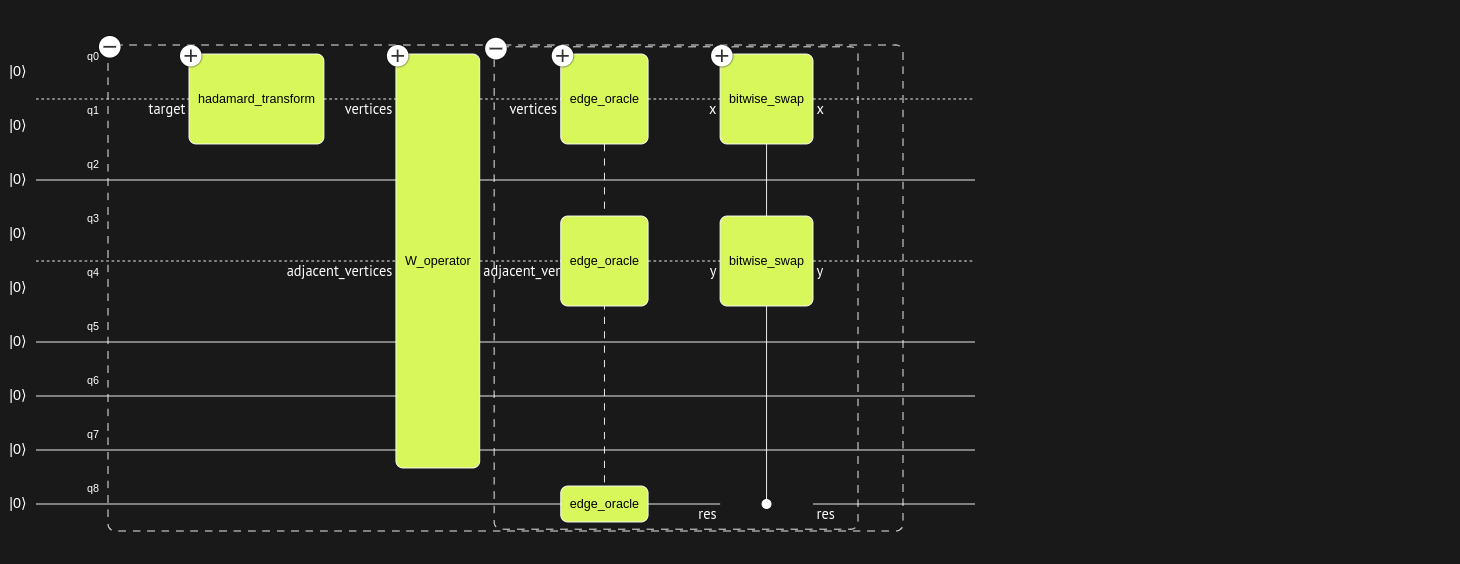

In [17]:
from IPython.display import Image, display

# Display the image
display(Image(filename='so1.jpg', embed=True))

For the W_operator we first have the state_preparation that prepares the probabilities for moving to adjacent vertices. For each node, this function sets the probability amplitudes for the walker to move to its neighboring nodes. Then, conditioned on a specific value we apply the zero_diffuzer to ensure that the probabilities are correctly distributed. Lastly, the state preparation inverse is applied, this operation blocks are repeted 4 times (one for each node). 


Since the circuit is ver wide, it's not possible to include it here. However, the image below depicts a segment of the quantum circuit corresponding to the W_operator applied in the quantum random walk algorithm.



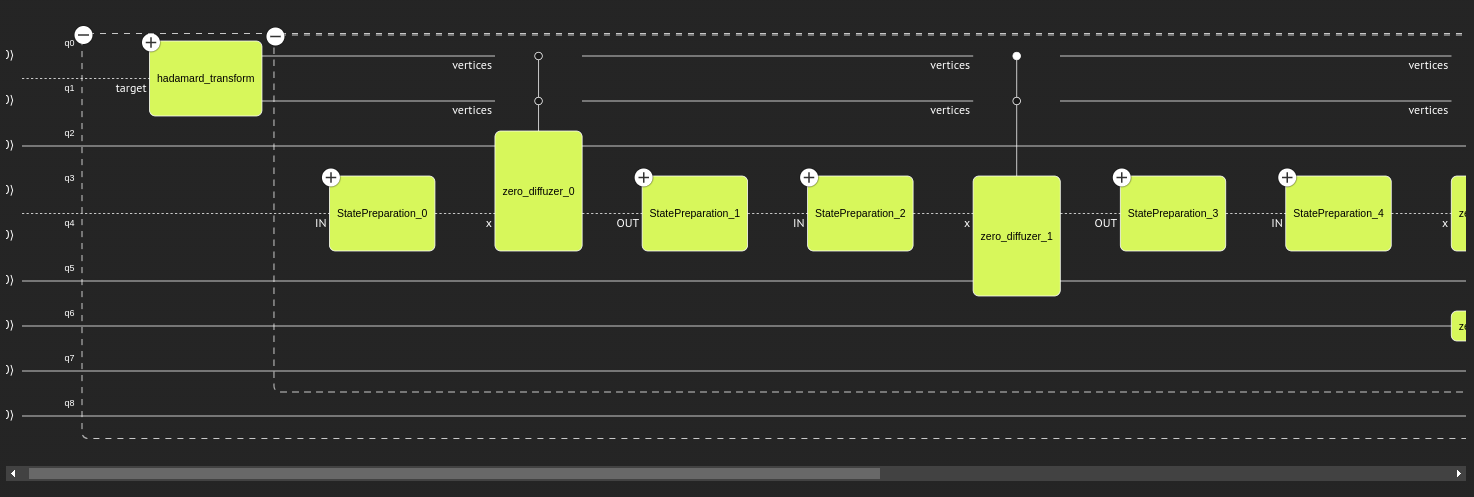

In [18]:
from IPython.display import Image, display

# Display the image
display(Image(filename='wo1.png', embed=True))



The results obtained from running the circuit 1000 times on the classiq simulator are as follows:





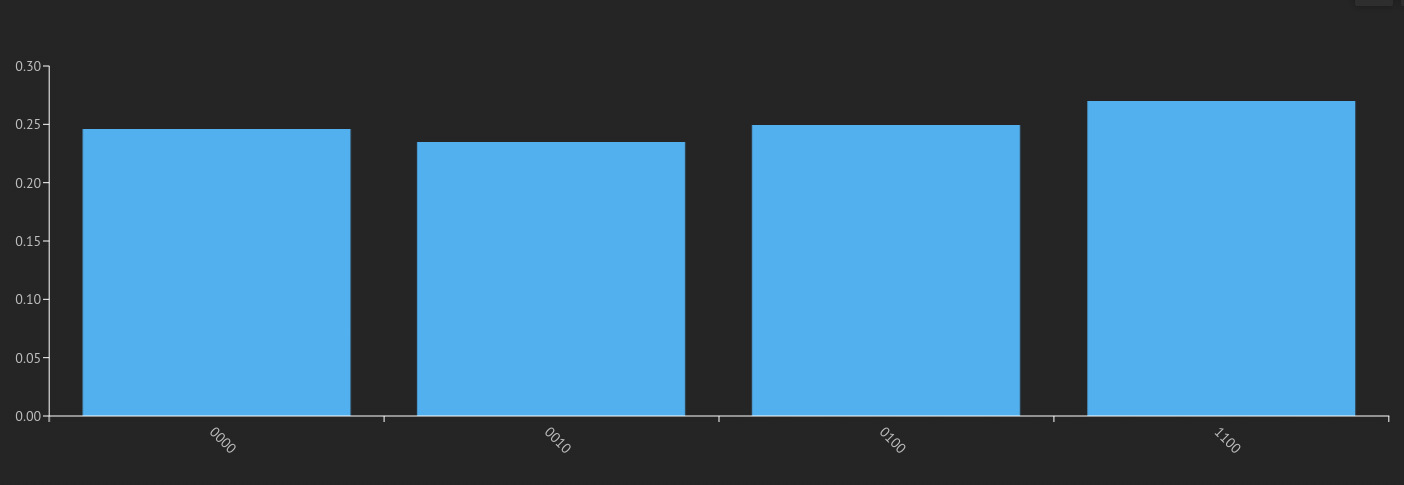

In [13]:
from IPython.display import Image, display

# Display the image
display(Image(filename='g1.png', embed=True))



For state 0000 we have a probability of 0.246

For state 0010 we have a probability of 0.235

For state 0100 we have a probability of 0.249

For state 1100 we have a probability of 0.270

These results indicate that the circuit is correctly simulating the quantum walk on the graph. The distribution of probabilities among the states aligns with the expected behavior, demonstrating that the quantum algorithm effectively explores the graph's structure. The slight variations in probabilities are due to the inherent randomness in quantum measurements and the finite number of runs. Overall, the simulation confirms that the quantum walk is implemented correctly, with the states corresponding to the expected adjacency relations and superposition principles.

      
          
--------------------------------------------------------------------------------------------------------



# Quantum Walk Operator for a Line with 16 Nodes
Follow the example from the 4th session for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes.
### Solution:

Now based on the previous case we want simulate a quantum random walk on a line topology with 16 nodes.

In a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. In this case, the line has 16 nodes numbered from 0 to 15. In this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability, except for the nodes at the ends of the line (0 and 15), which only have one adjacent neighbor.

First we will draw our graph 

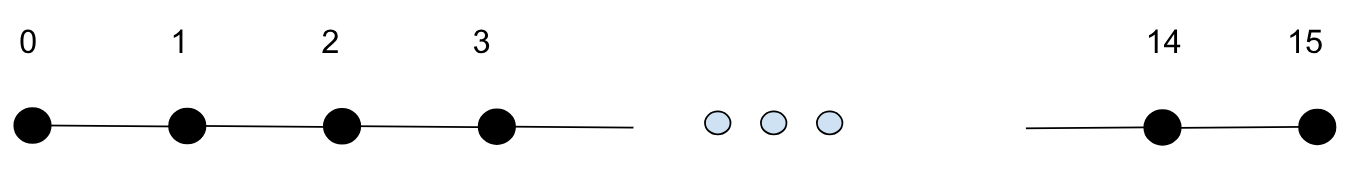

In [7]:

from IPython.display import Image, display

# Display the image
display(Image(filename='Fig1.png', embed=True))



Since we have 16 values we will need to consider 4 qubits, as $2^4=16$. Therefore, we set:
`size = 4`.

The probability vector will be: 
`prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]` 

We can use the condition that **Only if the sum of two vertices is odd**, they are connected by an edge. This means that if the sum of two vertices is odd, then there is an edge connecting them. For example:

For vertices 0 and 1: 0 + 1 = 1, which is odd, so they are connected by an edge.

For vertices 14 and 15: 14 + 15 = 29, which is odd, so they are connected by an edge.

However, we also need to introduce the condition that vertices 0 and 15 each have only one edge connecting them to another vertex. No modulo operation is needed because the connections do not wrap around. For Node 0, we only have Node 1 as a neighbor, and for Node 15, we only have Node 14 as a neighbor. All other nodes simply reference their adjacent nodes directly without wrapping.






In [20]:
#prob =  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Initialize the probability list
prob = [0] * 16  # Initialize probability vector for 16 nodes
for i in range(16):
    if i == 0:
        prob[1] = 1.0 # Only one neighbor to the right
    elif i == 15:
        prob[14] = 1.0  # Only one neighbor to the left
    else:
        prob[(i+1)] = 0.5  # Probability to the right node
        prob[(i-1)] = 0.5  # Probability to the left node

    # Print the probabilities for the current node for debugging
    print(f"Node {i}: {prob}")

    # Reset the probabilities for the next iteration
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 


Node 0: [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 1: [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 2: [0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 3: [0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 4: [0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 5: [0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node 6: [0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node 7: [0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node 8: [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node 9: [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node 13: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node 14: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node 15: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0]


In the main function we initialize the walker in a superposition of all possible positions along the line using the Hadamard gate, which creates an equal probability amplitude for the walker to be found at any of the 16 nodes. The walker's initial state can be represented as a superposition of basis states $\ket{0}, \ket{1}, \cdot \cdot \cdot ,\ket{15}$ where each basis state corresponds to one of the nodes.

### Code

In [21]:
from classiq import *

size = 4 # Adjust size for 16 nodes (2^4 = 16)

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    #prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    prob = [0] * 16  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[1] = 1.0  # Only one neighbor to the right
    elif i == 15:
        prob[14] = 1.0  # Only one neighbor to the left 
    else:
        prob[(i+1)] = 0.5  # Probability to the right node
        prob[(i-1)] = 0.5  # Probability to the left node   
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)

    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

For a line with 16 nodes, each node (except the endpoints) is connected to its immediate neighbor nodes, forming a linear structure. The quantum walk operator for this structure will ensure the proper superposition of adjacent vertices based on this linear connectivity.


The output results from running the quantum walk operator on the line with 16 nodes demonstrate the probability vectors for each state, which indicate the superposition of adjacent vertices.


State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]

State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]

State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]

State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]

State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]

State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]

State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]

State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]

State=14, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5]

State=15, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0]

Analysis of the Output

State 0: The probability vector [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] indicates that for state 0, the next state is 1 with a probability of 1, as expected for a line graph where node 0 is only connected to node 1.

State 1: The probability vector [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] indicates an equal superposition between nodes 0 and 2.

States 2 to 14: The probability vectors show an equal superposition between the adjacent nodes, confirming the correct implementation of the quantum walk operator for a line graph.

State 15: The probability vector [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0] indicates that for state 15, the previous state is 14 with a probability of 1, as expected for the endpoint of a line graph where node 15 is only connected to node 14.


The implementation of the quantum walk operator for a line with 16 nodes successfully demonstrates the principles of quantum superposition and adjacency relations. The probability vectors obtained from the simulation align with the expected outcomes, verifying the correctness of the quantum walk operator designed for this specific graph structure. 




After running the circuit we see that we have the following information about it

Depth: 2474

Width: 25

Gate count

U : 2125

CX : 1999



In the building block circuit for this problem we see that first we have the QNum vertices and adjacent_vertices, and several auxiliar qubits. We first apply the hadamard_transform on vertices, to create an equal superposition of all possible states (positions), allowing the walker to have a non-zero probability of being at any of the 16 nodes and then the W_operator (C operator) and the S_operator are applied.

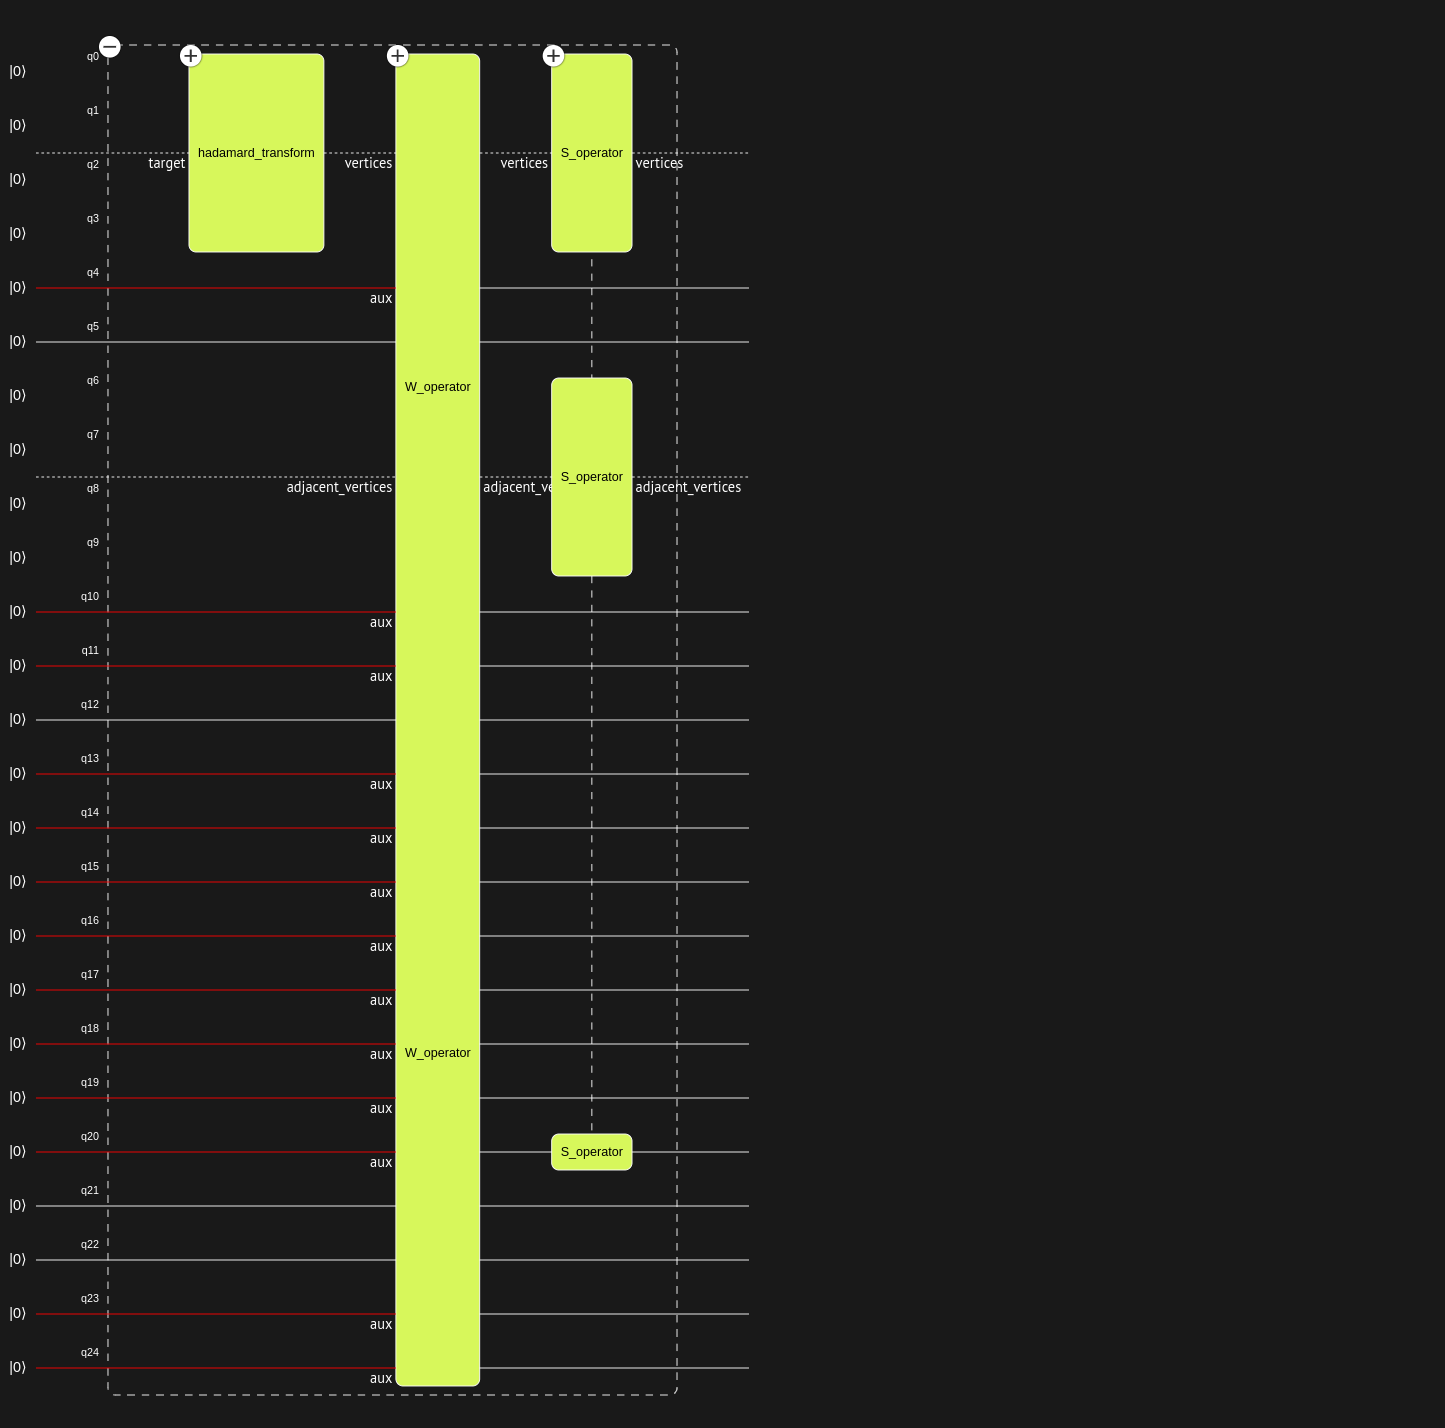

In [9]:
from IPython.display import Image, display

# Display the image
display(Image(filename='bb2.jpg', embed=True))


Zooming in the circuit we can observe that circuit implemented our desired algorithm correctly.




For the S_operator, we use an edge oracle to determine if there is an edge connecting a vertex to an adjacent vertex.  When the edge oracle confirms adjacency, a bitwise swap operation exchanges the states of the vertices and adjacent_vertices qubits. This swap operation simulates the walker's movement to the adjacent vertex. The dashed control lines indicate that the bitwise swap operation is conditional, based on the adjacency check by the edge oracle. This ensures that the swap only occurs if the vertices are indeed adjacent.




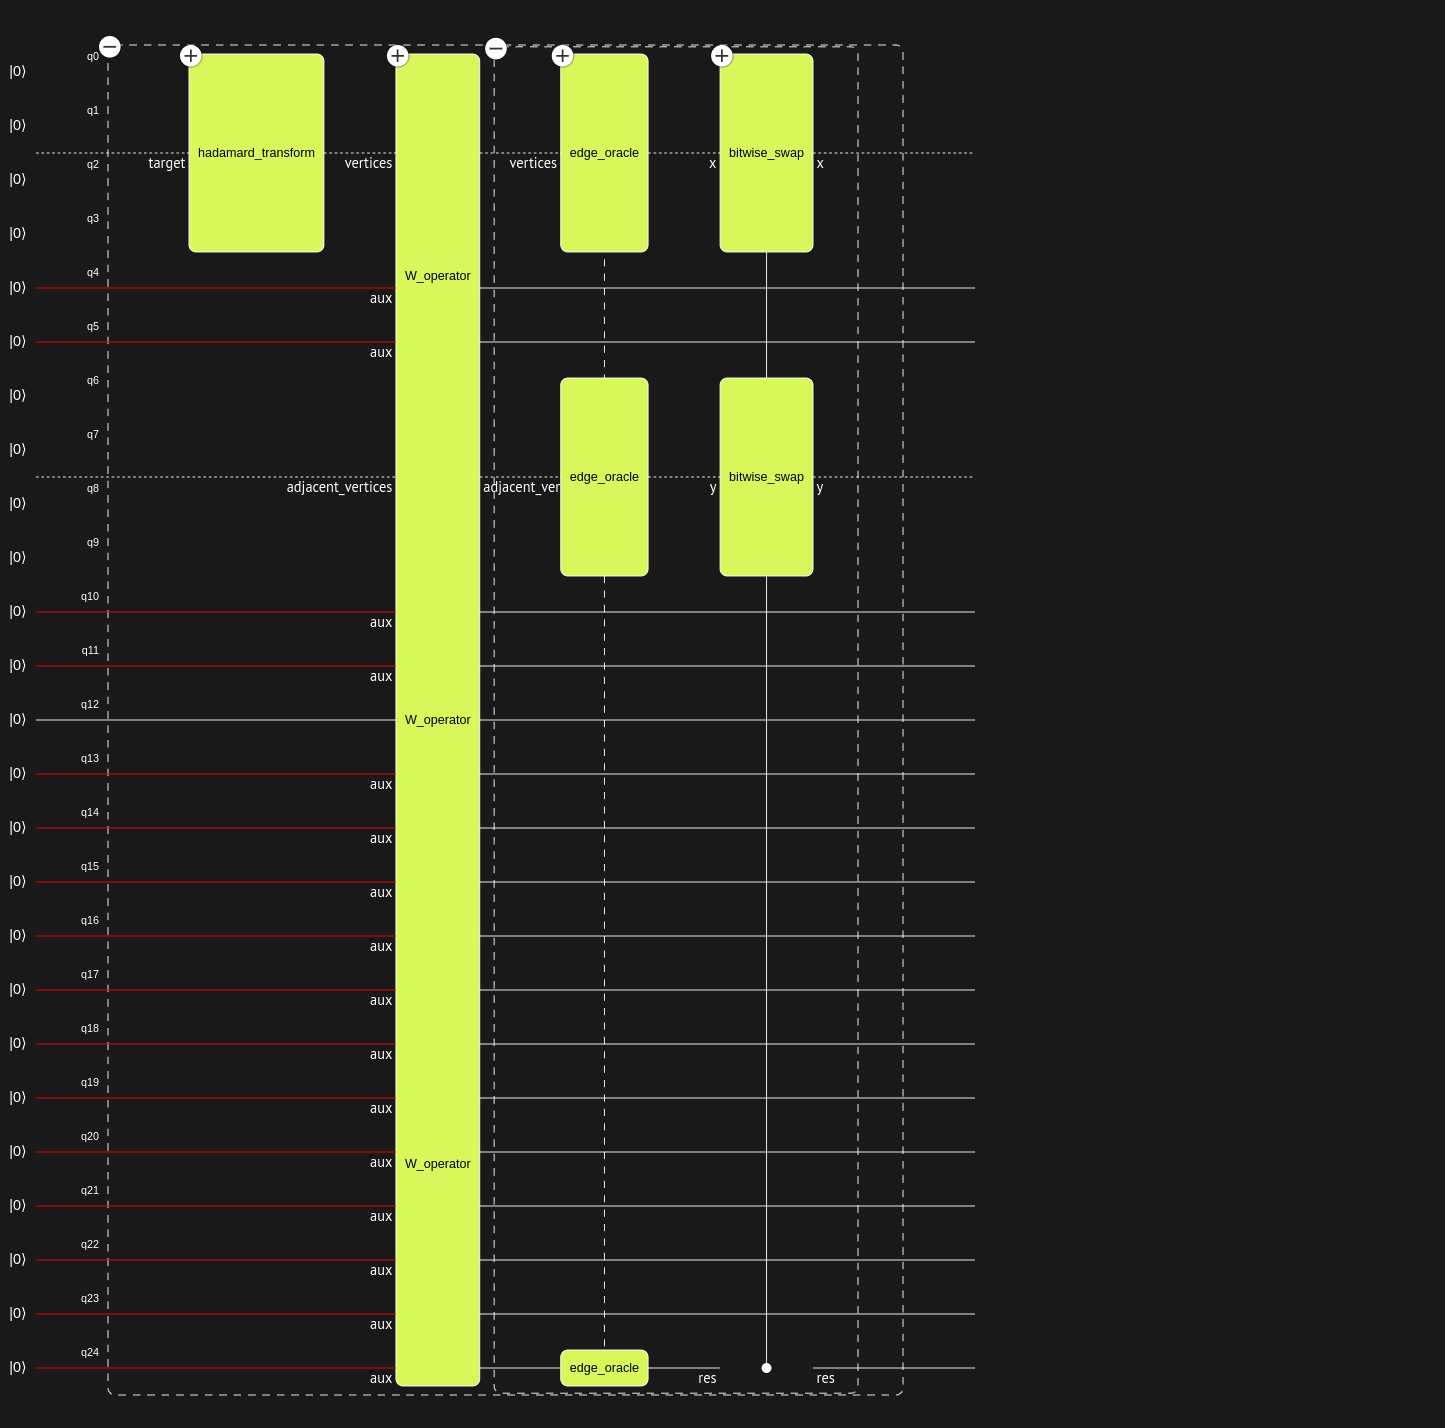

In [16]:
from IPython.display import Image, display

# Display the image
display(Image(filename='so2.jpg', embed=True))


For the W_operator we first have the state_preparation that prepares the probabilities for moving to adjacent vertices. For each node, this function sets the probability amplitudes for the walker to move to its neighboring nodes. Then, conditioned on a specific value we apply the zero_diffuzer to ensure that the probabilities are correctly distributed, for this, the auxiliary qubit (aux) is used to facilitate this operation. Lastly, the state preparation inverse is applied, this operation blocks are repeted 16 times (one for each node). 


Since the circuit is ver wide, it's not possible to include it here. However, the image below depicts a segment of the quantum circuit corresponding to the W_operator applied in the quantum random walk algorithm.



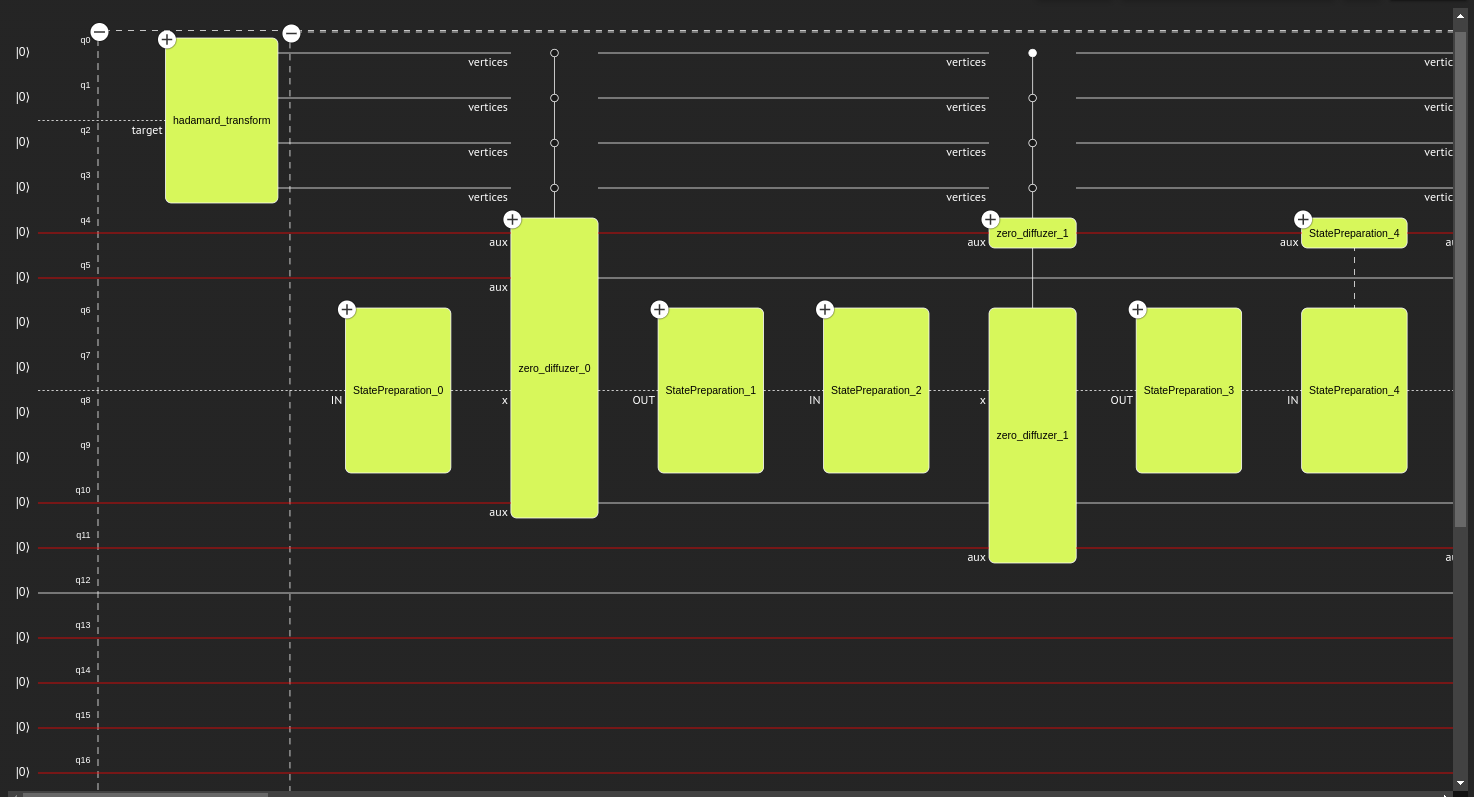

In [19]:
from IPython.display import Image, display

# Display the image
display(Image(filename='wo2.png', embed=True))



The results obtained from running the circuit 1000 times on the classiq simulator are as follows:




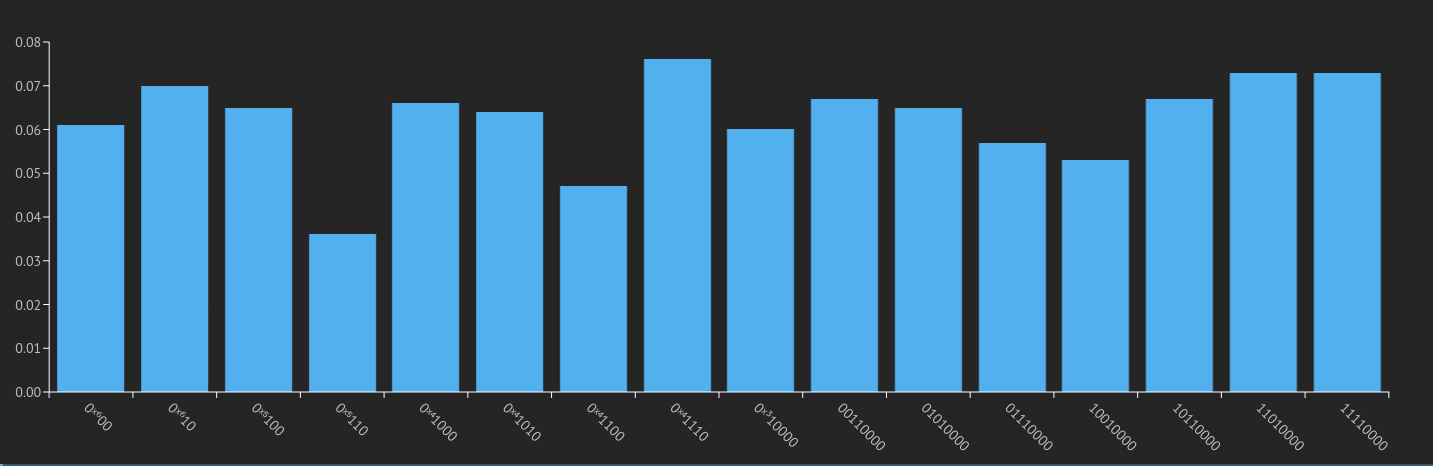

In [11]:
from IPython.display import Image, display

# Display the image
display(Image(filename='g2.png', embed=True))





For state 00000000 we have a probability of 0.061

For state 00000010 we have a probability of 0.070

For state 00000100 we have a probability of 0.065

For state 00000110 we have a probability of 0.036

For state 00001000 we have a probability of 0.066

For state 00001010 we have a probability of 0.064

For state 00001100 we have a probability of 0.047

For state 00001110 we have a probability of 0.076

For state 00010000 we have a probability of 0.060

For state 00110000 we have a probability of 0.067

For state 01010000 we have a probability of 0.065

For state 01110000 we have a probability of 0.057

For state 10010000 we have a probability of 0.053

For state 10110000 we have a probability of 0.067

For state 11010000 we have a probability of 0.073

For state 11110000 we have a probability of 0.073



These results indicate that the circuit is correctly simulating the quantum walk on the graph. The distribution of probabilities among the states aligns with the expected behavior, demonstrating that the quantum algorithm effectively explores the graph's structure. The probabilities for each state reflect the quantum walk's ability to traverse the graph according to the defined adjacency relations.

The slight variations in probabilities are expected and can be attributed to the inherent randomness in quantum measurements and the finite number of runs. In quantum simulations, such variations are normal and do not detract from the overall validity of the results.



### Discussion

In the exploration of quantum algorithms, specifically quantum walks, we have delved into encoding classical graph data into quantum states. Following the guidance from the "Lecture Notes on Quantum Algorithms," we understood that vertices in a graph are represented by quantum states $\ket{j}$, where $j \in V$. This encoding leverages the quantum variable QNum, which allows us to represent vertices as quantum states.

One critical aspect was the implementation of the operators C and S, which are fundamental in the evolution of the quantum walk. The operator C is constructed using the concept of superposition and projections. We applied the Hadamard transform to create superpositions and iteratively summed over all vertices using the modulo operator to manage the cyclic nature of our graph structure. This ensures that each vertex is correctly connected to its adjacent vertices in the superposition state $\ket{\partial_j}$.

The S operator, on the other hand, is responsible for swapping states based on the edges of the graph. This operator utilizes an oracle, which determines whether two vertices are connected by an edge. For our specific graph, we defined the condition that the sum of two vertices is odd, indicating an edge between them. This oracle checks the condition and applies a swap if the vertices are connected.

To initialize our quantum walk, we allocated and prepared the quantum variables vertices and adjacent_vertices, ensuring they were in the desired superposition states. The implementation of the W operator involved applying the prepared probability vectors to adjacent_vertices and using the within-apply construct to manage basis changes and apply the zero diffuser operator.

When extending our analysis to a larger line graph with 16 vertices, we maintained the condition that the sum of two vertices being odd signifies an edge. However, we also introduced additional conditions to ensure correct edge connections for boundary vertices, such as vertices 0 and 15.

### Conclusion

The study and implementation of quantum walks provide a profound insight into the potential of quantum algorithms in solving classical problems. By encoding vertices as quantum states and using operators C and S, we can simulate the evolution of a quantum walk on a graph. The use of superposition, projection, and oracles showcases the power of quantum computation in handling complex data structures.

Our exploration highlighted the importance of carefully defining the conditions for vertex connections and managing basis changes during operator applications. For the larger graph with 16 vertices, we ensured correct edge connections by introducing specific conditions, such as vertices being connected if their sum is odd. This approach ensured that the adjacency relationships were accurately represented without needing the modulo operator, as the connections did not wrap around cyclically. This precise definition of edge conditions is crucial for the accurate implementation of quantum walks on larger graphs.



As quantum computing continues to advance, the techniques and methodologies discussed here will be instrumental in developing more sophisticated quantum algorithms. This work lays the foundation for future research and application of quantum walks in various domains, including optimization, search algorithms, and quantum simulation of complex systems.








# Bibliography

[1] Childs, A. M. (2017). Lecture notes on quantum algorithms. Lecture notes at University of Maryland, 5.